In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mpltern

In [2]:
# example dataset
example_df = pd.DataFrame(
    {
        "sample_id": ["S1", "S2", "S3", "S4", "S5"],
        "sand": [65, 70, 75, 80, 35],
        "silt": [20, 24, 21, 16, 45],
        "clay": [15, 6, 4, 4, 20],
        "BD": [1.002, 1.277, 1.008, 1.927, 1.774],
    }
)

In [3]:
# Check texture classes from soiltexture package
from soiltexture import getTexture
example_df.apply(
    lambda row: getTexture(row['sand'], row['clay']), axis=1
)

0    sandy loam
1    sandy loam
2    loamy sand
3    loamy sand
4          loam
dtype: object

In [ ]:
tri.classify()

,sample_id,sand,silt,clay,BD,texture_class
0,S1,65,20,15,1.002,sandy loam
1,S2,70,24,6,1.277,sandy loam
2,S3,75,21,4,1.008,loamy sand
3,S4,80,16,4,1.927,loamy sand
4,S5,35,45,20,1.774,loam


In [4]:
# example_df.to_csv("example_soil_data.csv", index=False)

In [7]:
tri.df

,sample_id,sand,silt,clay,BD,texture_class
0,S1,65,20,15,1.002,sandy loam
1,S2,70,24,6,1.277,sandy loam
2,S3,75,21,4,1.008,loamy sand
3,S4,80,16,4,1.927,loamy sand
4,S5,35,45,20,1.774,loam


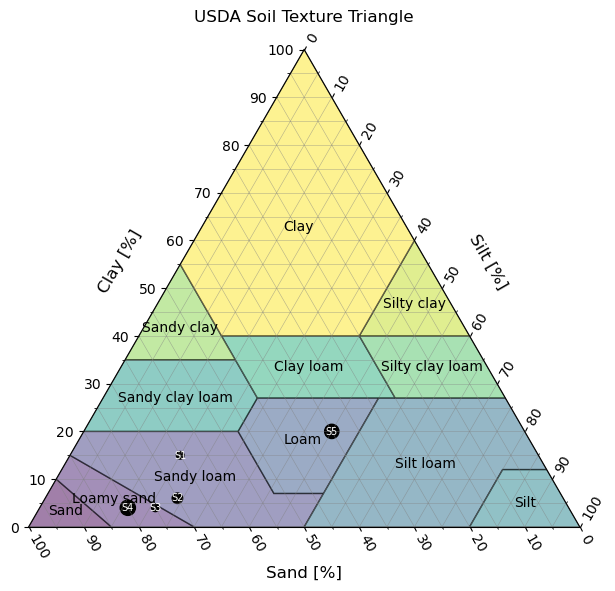

In [5]:
from soiltextureplot.triangle import SoilTextureTriangle

tri = SoilTextureTriangle(system_name="USDA")
tri.load_dataframe(example_df)
# tri.classify()
fig, ax = tri.plot(size_by="BD", cmap="viridis")

In [7]:
from soiltextureplot.systems import list_texture_systems

list_texture_systems()

{'USDA': 'United States Department of Agriculture (USDA) Soil Texture Classification',
 'HYPRES': 'The HYdraulic PRoperties of European Soils (HYPRES) is a European framework for classifying soils based on their hydrologic properties'}